In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as opt

In [2]:
%load_ext klab-autotime

In [3]:
data = loadmat('../data_files/data/ex4data1.mat')

time: 93.4 ms


In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

time: 4.02 ms


In [5]:
X,y = data['X'],data['y'].flatten()
X.shape,y.shape

((5000, 400), (5000,))

time: 4.14 ms


In [6]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

time: 2.48 ms


In [7]:
weights = loadmat('../data_files/data/ex4weights.mat')

time: 3.11 ms


In [8]:
weights

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

time: 4.74 ms


In [9]:
theta1,theta2 = weights['Theta1'],weights['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

time: 1.78 ms


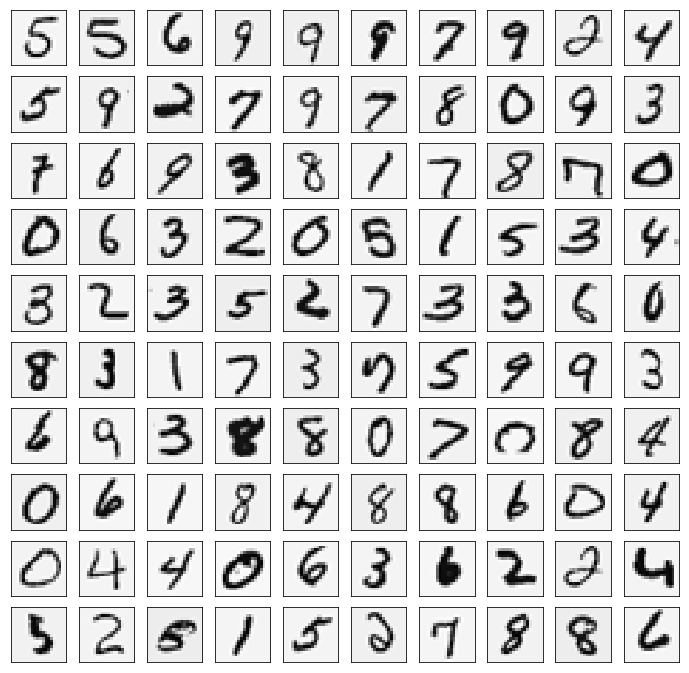

time: 3.28 s


In [10]:
sample_idx = np.random.choice(np.arange(X.shape[0]),100)
sample_images = data['X'][sample_idx, :]
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T,cmap='gray_r')
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

time: 421 µs


In [12]:
def deserialize(seq):
    '''提取参数'''
    return seq[:25*401].reshape(25, 401), seq[25*401:].reshape(10, 26)

time: 2.24 ms


In [13]:
def serialize(a, b):
    '''展开参数'''
    return np.r_[a.flatten(),b.flatten()]

time: 2.09 ms


In [14]:
theta = serialize(theta1,theta2)

time: 1.69 ms


In [15]:
X = np.insert(X,0,1,axis=1)
X.shape,y.shape

((5000, 401), (5000,))

time: 14 ms


In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse= False)
y_onehot = encoder.fit_transform(y.reshape(-1,1))
y_onehot.shape

(5000, 10)

time: 149 ms


In [17]:
y[0], y_onehot[0,:]

(10, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

time: 1.89 ms


In [18]:
y = y_onehot

time: 1.11 ms


In [19]:
# 前向传播函数
def forward_propagate(theta, X):
    theta1,theta2 = deserialize(theta)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = np.insert(sigmoid(z2),0,values=1,axis=1)
    z3 = a2 @ theta2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h

time: 690 µs


In [20]:
def cost(theta,X,y):
    a1, z2, a2, z3, h = forward_propagate(theta, X)
    J = 0
    for i in range(len(X)):
        first = - y[i] * np.log(h[i])
        second = (1 - y[i]) * np.log(1 - h[i])
        J = J + np.sum(first - second)
    J = J / len(X)
    return J

time: 723 µs


In [21]:
cost(theta, X, y)

0.2876291651613188

time: 100 ms


In [22]:
def costReg(theta,X,y,learning_rate=1):
    theta1,theta2 = deserialize(theta)
    a1,z2,a2,z3,h = forward_propagate(theta, X)
    J = 0
    reg = np.sum(theta1[:,1:] ** 2) + np.sum(theta2[:,1:] ** 2)
    J = (learning_rate / (2 * len(X))) * reg + cost(theta,X,y)
    return J

time: 613 µs


In [23]:
costReg(theta,X,y)

0.38376985909092354

time: 103 ms


In [24]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

time: 387 µs


In [25]:
sigmoid_gradient(0)

0.25

time: 4.54 ms


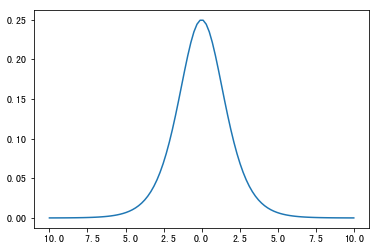

time: 159 ms


In [26]:
n = np.linspace(-10,10,100)
plt.plot(n,sigmoid_gradient(n))

In [27]:
def random_init(size):
    '''从服从的均匀分布的范围中随机返回size大小的值'''
    return np.random.uniform(-0.12, 0.12, size)

time: 427 µs


In [28]:
a1, z2, a2, z3, h = forward_propagate(theta, X)

time: 16.5 ms


In [29]:
print('a1', a1.shape,'theta1', theta1.shape)
print('z2', z2.shape)
print('a2', a2.shape, 'theta2', theta2.shape)
print('z3', z3.shape)
print('a3', h.shape)

a1 (5000, 401) theta1 (25, 401)
z2 (5000, 25)
a2 (5000, 26) theta2 (10, 26)
z3 (5000, 10)
a3 (5000, 10)
time: 950 µs


In [30]:
def backpropagation(theta,X,y):
    a1,z2,a2,z3,h = forward_propagate(theta, X)
    t1,t2 = deserialize(theta) 
    d3 = h - y # (5000, 10)
    d2 = d3 @ t2[:,1:] * sigmoid_gradient(z2)  # (5000, 25)
    D2 = d3.T @ a2  # (10, 26)
    D1 = d2.T @ a1 # (25, 401)
    D = (1 / len(X)) * serialize(D1, D2)  # (10285,)
    return D

time: 739 µs


In [31]:
def regularized_gradient(theta,X,y,learning_rate=1):
    a1,z2,a2,z3,h = forward_propagate(theta, X)
    D = backpropagation(theta, X, y)
    theta1,theta2 = deserialize(theta)
    D1, D2 = deserialize(backpropagation(theta, X, y))
    theta1[:0] = 0 
    theta2[:0] = 0
    reg_D1 = D1 + (learning_rate / len(X)) * theta1
    reg_D2 = D2 + (learning_rate / len(X)) * theta2
    return serialize(reg_D1,reg_D2)

time: 774 µs


In [32]:
import scipy.optimize as opt
from sklearn.metrics import classification_report  # 这个包是评价报告

time: 7.11 ms


In [33]:
def nn_training(X, y):
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=costReg,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

time: 448 µs


In [34]:
res = nn_training(X, y)
res

     fun: 0.3159732265329833
     jac: array([ 3.96126561e-05, -1.45542437e-07, -4.44482354e-07, ...,
        1.42838311e-05,  1.31603337e-05,  1.27186966e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 30
  status: 3
 success: False
       x: array([-7.22619457e-01, -7.27712185e-04, -2.22241177e-03, ...,
       -6.75894149e-01, -2.46241596e+00, -1.10389364e+00])

time: 1min 8s


In [35]:
def accuracy(theta, X, y):
    _, _, _, _, h = forward_propagate(res.x, X)
    y_pred = np.argmax(h, axis=1) + 1
    print(classification_report(y, y_pred))

time: 559 µs


In [40]:
raw_y = data['y'].flatten()
raw_y

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

time: 2.14 ms


In [41]:
accuracy(res.x, X, raw_y)

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       0.99      0.99      0.99       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

time: 22.8 ms


In [42]:
def plot_hidden(theta):
    t1, _ = deserialize(theta)
    t1 = t1[:, 1:]
    fig,ax_array = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(6,6))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(t1[r * 5 + c].reshape(20, 20), cmap='gray_r')
            plt.xticks([])
            plt.yticks([])
    plt.show()

time: 681 µs


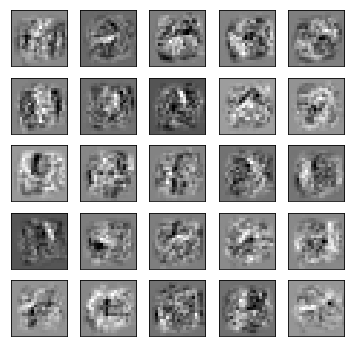

time: 781 ms


In [43]:
plot_hidden(res.x)